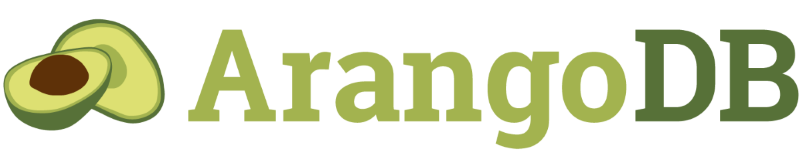

<a href="https://colab.research.google.com/github/arangodb/interactive_tutorials/blob/master/notebooks/arangoflix/similarMovie_MF_ML_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Matrix Factorization-based Recommendation
"This is an implementation using matrix factorization The model uses Matrix Factotization to compute similarity between movies and similarity between users. An AQL query retrieves user ratings on movies from the Movie Knowledge Graph for machine learning. The simularity between each movie is computed using Matrix Factorization and FAISS to compute the top movie simularities. The movie simularities are communicated as inferences to the Movie Knowledge Graph as similar movie edges with a similarity score. An AQL query then finds the most highly rated movies by the given user (user-a) and then uses the movie similarity inference to compute the set of movies most like the highest rated movies from specific user"

#Setup Interactive Demo Environment

In [2]:
%%capture
!git clone -b oasis_connector --single-branch https://github.com/arangodb/interactive_tutorials.git
!mkdir data
!git clone -b movie-data-source --single-branch https://github.com/arangodb/interactive_tutorials.git movie_data_source
!git clone -b oasis_connector https://github.com/arangodb/interactive_tutorials oasis
!rsync -av oasis/ ./ --exclude=.git
!chmod -R 755 ./data
!chmod -R 755 ./tools
!chmod -R 755 ./oasis

## Install ArangoML Components

In [104]:
%%capture
!pip3 install pyarango
!pip3 install python-arango
!pip install surprise
!pip install faiss-cpu 
!pip install datapane

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import requests
from PIL import Image
from io import BytesIO
import urllib.request
import io
from arango import ArangoClient
from tqdm import tqdm
import faiss
from faiss import normalize_L2
import oasis

In [5]:
# unzip movies dataset zip file
!unzip ./movie_data_source/sampled_movie_dataset.zip

Archive:  ./movie_data_source/sampled_movie_dataset.zip
   creating: sampled_movie_dataset/
  inflating: sampled_movie_dataset/links_small.csv  
  inflating: __MACOSX/sampled_movie_dataset/._links_small.csv  
  inflating: sampled_movie_dataset/.DS_Store  
  inflating: __MACOSX/sampled_movie_dataset/._.DS_Store  
  inflating: sampled_movie_dataset/movies_metadata.csv  
  inflating: __MACOSX/sampled_movie_dataset/._movies_metadata.csv  
  inflating: sampled_movie_dataset/ratings_small.csv  
  inflating: __MACOSX/sampled_movie_dataset/._ratings_small.csv  


In [6]:
metadata_path = './sampled_movie_dataset/movies_metadata.csv'
df = pd.read_csv(metadata_path)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [8]:
df.poster_path

0        /rhIRbceoE9lR4veEXuwCC2wARtG.jpg
1        /vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg
2        /6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg
3        /16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg
4        /e64sOI48hQXyru7naBFyssKFxVd.jpg
                       ...               
45461    /jldsYflnId4tTWPx8es3uzsB1I8.jpg
45462    /xZkmxsNmYXJbKVsTRLLx3pqGHx7.jpg
45463    /d5bX92nDsISNhu3ZT69uHwmfCGw.jpg
45464    /aorBPO7ak8e8iJKT5OcqYxU3jlK.jpg
45465    /s5UkZt6NTsrS7ZF0Rh8nzupRlIU.jpg
Name: poster_path, Length: 45466, dtype: object

In [9]:
# on these rows metadata information is missing
df = df.drop([19730, 29503, 35587])

In [11]:
# sampled from links.csv file
links_small = pd.read_csv('./sampled_movie_dataset/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [12]:
df['id'] = df['id'].astype('int')

In [13]:
df.shape

(45463, 24)

In [14]:
sampled_md = df[df['id'].isin(links_small)]
sampled_md.shape

(9099, 24)

In [15]:
sampled_md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [16]:
sampled_md['tagline'] = sampled_md['tagline'].fillna('')
sampled_md['description'] = sampled_md['overview'] + sampled_md['tagline']
sampled_md['description'] = sampled_md['description'].fillna('')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [17]:
# compute tf-idf features
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(sampled_md['description'])

In [18]:
tfidf_matrix.shape

(9099, 268124)

In [19]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [20]:
sampled_md = sampled_md.reset_index()
titles = sampled_md['title']
indices = pd.Series(sampled_md.index, index=sampled_md['title'])

In [21]:
sampled_md.iloc[521]['title']

'Aladdin'

In [22]:
# The Dark Knight
def content_based_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    movies = sampled_md.iloc[movie_indices][['title', 'id', 'poster_path']]
    #return titles.iloc[movie_indices]
    return movies

In [23]:
content_rec = content_based_recommendations('The Dark Knight').head(10)

In [24]:
def fetch_poster(rec_mids):
    rec_posters = []
    for movie_id in rec_mids:  
        url = "https://api.themoviedb.org/3/movie/{}?api_key=8265bd1679663a7ea12ac168da84d2e8&language=en-US".format(movie_id)
        data = requests.get(url)
        data = data.json()
        poster_path = data['poster_path']
        full_path = "https://image.tmdb.org/t/p/w500/" + poster_path
        rec_posters.append(full_path)
    return rec_posters

In [25]:
c_rec_posters = fetch_poster(content_rec['id'].tolist())

In [26]:
def create_np_imgs(rec_posters):
    np_imgs = []
    for posters in rec_posters:
        with urllib.request.urlopen(posters) as url:
            f = io.BytesIO(url.read())
            img = Image.open(f)
            #img = img.resize((250,250), Image.ANTIALIAS)
            img = np.asarray(img)
            np_imgs.append(img)
    return np_imgs

In [27]:
c_np_imgs = create_np_imgs(c_rec_posters)

In [28]:
def show_images(images, cols = 2, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, int(np.ceil(n_images/float(cols))), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [29]:
show_images(c_np_imgs, titles=content_rec['title'].tolist())

Output hidden; open in https://colab.research.google.com to view.

# Collaborative Filtering

In [30]:
from surprise import SVD, Reader
from surprise import Dataset
from surprise.model_selection import cross_validate


In [31]:
reader = Reader()

In [32]:
ratings = pd.read_csv('./sampled_movie_dataset/ratings_small.csv')

ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [33]:
print('Number of unique movies in ratings file:', len(set((ratings['movieId'].tolist()))))

Number of unique movies in ratings file: 9066


In [34]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [35]:
# Use the famous SVD algorithm.
algo = SVD()

In [36]:
# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9037  0.8872  0.9008  0.8865  0.9014  0.8959  0.0075  
MAE (testset)     0.6968  0.6831  0.6947  0.6830  0.6931  0.6901  0.0059  
Fit time          4.86    4.90    4.84    5.07    4.92    4.92    0.08    
Test time         0.19    0.26    0.49    0.24    0.26    0.29    0.10    


{'fit_time': (4.860152006149292,
  4.898286581039429,
  4.842841625213623,
  5.06969428062439,
  4.923837184906006),
 'test_mae': array([0.6967968 , 0.68314113, 0.69473277, 0.68295776, 0.69308867]),
 'test_rmse': array([0.9036888 , 0.88716266, 0.90081335, 0.8865178 , 0.90140012]),
 'test_time': (0.19151949882507324,
  0.26377058029174805,
  0.48682618141174316,
  0.2391207218170166,
  0.25545406341552734)}

Train dataset and compute predictions

In [37]:
trainset = data.build_full_trainset()
algo.fit(trainset)

In [38]:
# ratings file stats
print('Total number of movies:', trainset.n_items)
print('Total number of users:', trainset.n_users)
print('Total number of ratings:', trainset.n_ratings)
print('Ratings Scale:', trainset.rating_scale)
print('The mean of all ratings:', trainset.global_mean)


Total number of movies: 9066
Total number of users: 671
Total number of ratings: 100004
Ratings Scale: (1, 5)
The mean of all ratings: 3.543608255669773


In [39]:
for idx, m_iid in enumerate(trainset.all_items()):
    print('index:',idx, 'Movie Inner ID', m_iid, trainset.to_raw_iid(m_iid))

Streaming output truncated to the last 5000 lines.
index: 4066 Movie Inner ID 4066 117123
index: 4067 Movie Inner ID 4067 118082
index: 4068 Movie Inner ID 4068 126006
index: 4069 Movie Inner ID 4069 130642
index: 4070 Movie Inner ID 4070 130682
index: 4071 Movie Inner ID 4071 135887
index: 4072 Movie Inner ID 4072 139130
index: 4073 Movie Inner ID 4073 141718
index: 4074 Movie Inner ID 4074 141866
index: 4075 Movie Inner ID 4075 152091
index: 4076 Movie Inner ID 4076 152844
index: 4077 Movie Inner ID 4077 156726
index: 4078 Movie Inner ID 4078 159462
index: 4079 Movie Inner ID 4079 161594
index: 4080 Movie Inner ID 4080 162376
index: 4081 Movie Inner ID 4081 2106
index: 4082 Movie Inner ID 4082 2549
index: 4083 Movie Inner ID 4083 4799
index: 4084 Movie Inner ID 4084 8985
index: 4085 Movie Inner ID 4085 42002
index: 4086 Movie Inner ID 4086 44694
index: 4087 Movie Inner ID 4087 2275
index: 4088 Movie Inner ID 4088 2450
index: 4089 Movie Inner ID 4089 3264
index: 4090 Movie Inner ID 40

In [40]:
# generate movie_ids from trainset
m_id = [trainset.to_raw_iid(item) for item in trainset.all_items()]

## Generating Rating Predictions

In [41]:
algo.predict(2, 100)

Prediction(uid=2, iid=100, r_ui=None, est=3.3366250638483015, details={'was_impossible': False})

movie embeddings shape: number of movies, n_factor

n_factor: Each row represents an item with n_factor number of factors, 
these are the so-called latent factors that the model found and they represent the item in the rating calculations.

In [42]:
print(algo.qi.shape)

(9066, 100)


In [43]:
print(algo.pu.shape)

(671, 100)


In [44]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [45]:
id_map = pd.read_csv('./sampled_movie_dataset/links_small.csv')[['movieId', 'tmdbId']]


In [46]:
id_map

,movieId,tmdbId
0,1,862.0
1,2,8844.0
2,3,15602.0
3,4,31357.0
4,5,11862.0
...,...,...
9120,162672,402672.0
9121,163056,315011.0
9122,163949,391698.0
9123,164977,137608.0


In [47]:
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)


In [48]:
id_map.columns = ['movieId', 'id']


In [49]:
id_map

,movieId,id
0,1,862.0
1,2,8844.0
2,3,15602.0
3,4,31357.0
4,5,11862.0
...,...,...
9120,162672,402672.0
9121,163056,315011.0
9122,163949,391698.0
9123,164977,137608.0


In [50]:
sampled_md[['title', 'id']]

,title,id
0,Toy Story,862
1,Jumanji,8844
2,Grumpier Old Men,15602
3,Waiting to Exhale,31357
4,Father of the Bride Part II,11862
...,...,...
9094,Shin Godzilla,315011
9095,The Beatles: Eight Days a Week - The Touring Y...,391698
9096,Pokémon: Spell of the Unknown,10991
9097,Pokémon 4Ever: Celebi - Voice of the Forest,12600


In [51]:
# tmbdid is same (of links_small) as of id in sampled_ms
id_map = id_map.merge(sampled_md[['title', 'id']], on='id').set_index('title')

In [52]:
id_map

,movieId,id
title,,
Toy Story,1,862.0
Jumanji,2,8844.0
Grumpier Old Men,3,15602.0
Waiting to Exhale,4,31357.0
Father of the Bride Part II,5,11862.0
...,...,...
The Last Brickmaker in America,161944,159550.0
Rustom,162542,392572.0
Mohenjo Daro,162672,402672.0


In [53]:
row = id_map.loc[id_map['movieId'] == 720]

In [54]:
row.size

0

In [55]:
indices_map = id_map.set_index('id')

In [56]:
indices_map 

,movieId
id,
862.0,1
8844.0,2
15602.0,3
31357.0,4
11862.0,5
...,...
159550.0,161944
392572.0,162542
402672.0,162672


In [57]:
r = sampled_md.loc[sampled_md['id'] == 9909]

In [58]:
r.iloc[0]['title']

'Dangerous Minds'

In [59]:
def hybrid_engine(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]

    movies = sampled_md.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'poster_path' ,'id']]
    movies['est'] = movies['id'].apply(lambda x: algo.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(5)

In [60]:
h_rec_movies = hybrid_engine(2, 'Aladdin')

In [61]:
h_posters = fetch_poster(h_rec_movies['id'].tolist())

In [62]:
# posters to np imgs
h_np_posters = create_np_imgs(h_posters)


In [63]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

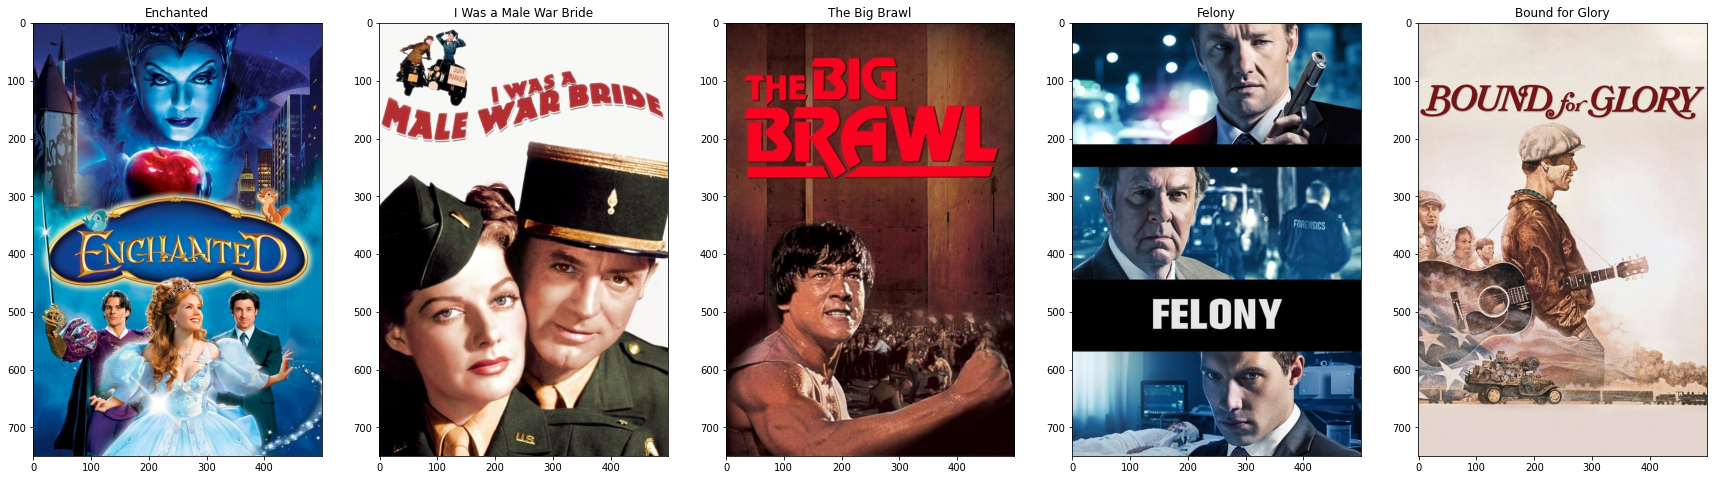

In [64]:
show_images(h_np_posters, titles=h_rec_movies['title'].tolist())

# ArangoDB Setup

In [65]:
# # Initialize the ArangoDB client.
# client = ArangoClient("http://127.0.0.1:8529")
# get temporary credentials for ArangoDB on cloud
login = oasis.getTempCredentials(tutorialName="MovieRecommendations", credentialProvider="https://tutorials.arangodb.cloud:8529/_db/_system/tutorialDB/tutorialDB")

# Connect to the temp database
# Please note that we use the python-arango driver as it has better support for ArangoSearch 
movie_rec_db = oasis.connect_python_arango(login)

# url to access the ArangoDB Web UI
print("https://"+login["hostname"]+":"+str(login["port"]))
print("Username: " + login["username"])
print("Password: " + login["password"])
print("Database: " + login["dbName"])


Requesting new temp credentials.
Temp database ready to use.
https://tutorials.arangodb.cloud:8529
Username: TUTatbjk5r919djv4xk43nd4
Password: TUTenc62ts7juhh808r12ko
Database: TUT0dszg1ktzo163cjprgn3o


In [67]:
# create a new collection named "Movie Embeddings" if it does not exist.
# This returns an API wrapper for "Movie Embeddings" collection.
if not movie_rec_db.has_collection("movie_embeddings"):
    movie_rec_db.create_collection("movie_embeddings", replication_factor=3)

In [68]:
# movie embeddings
movie_emb = algo.qi
print(type(movie_emb))

<class 'numpy.ndarray'>


In [69]:
batch = []
BATCH_SIZE = 128
batch_idx = 1
index = 0
movie_collection = movie_rec_db["movie_embeddings"]

In [70]:
for idx in tqdm(range(movie_emb.shape[0])):
    insert_doc = {}
    tmdb_id = id_map.loc[id_map['movieId'] == m_id[idx]]
  
    # if tmdb_id.size == 0:
    #     pass
    # else:
    # tmdb_id = int(tmdb_id.iloc[:,1][0])
    # m_meta = sampled_md.loc[sampled_md['id'] == tmdb_id]
    # m_title = m_meta.iloc[0]['title']
    # m_poster = m_meta.iloc[0]['poster_path']
    # m_description = m_meta.iloc[0]['description']
    insert_doc["movieId"] = m_id[idx]
    insert_doc["_key"] = f"{m_id[idx]}"
    insert_doc['movie_embeddings'] = movie_emb[idx].tolist()


    batch.append(insert_doc)
    index +=1
    last_record = (idx == (movie_emb.shape[0] - 1))
    if index % BATCH_SIZE == 0:
        #print("Inserting batch %d" % (batch_idx))
        batch_idx += 1
        movie_collection.import_bulk(batch)
        batch = []   
    if last_record and len(batch) > 0:
        print("Inserting batch the last batch!")
        movie_collection.import_bulk(batch)

100%|██████████| 9066/9066 [00:10<00:00, 846.91it/s]

Inserting batch the last batch!


In [71]:
movie_emb = np.float32(movie_emb)

In [72]:
movie_emb.shape

(9066, 100)

## Role of Faiss

In [73]:
dimension = 100
n_vectors = 9066
nlist = 5
quantiser = faiss.IndexFlatL2(dimension)  

We use the ‘IndexIVFFlat’ index type for our vectors. The ‘Flat’ here signifies that the vectors are stored as is without any compression or quantisation.

The IVF index takes two parameters:

nlist : to specify the number of clusters to be formed

quantizer : to assign the vectors to a particular cluster. This is usually another index that uses the L2 distance metric (we use the FlatL2 index)

In [74]:
search_index = faiss.IndexIVFFlat(quantiser, dimension, nlist,   faiss.METRIC_L2)

In [75]:
print(search_index.is_trained)   


False


The index has to be trained initially to create ‘n_cluster’ number of clusters and then the vectors are added to these clusters. the ‘is_trained’ flag denotes whether the index is trained or not and the ‘ntotal’ attribute shows the total number of vectors added to the index.


In [76]:
# train on movie embs/vectors
search_index.train(movie_emb)

In [77]:
print(search_index.ntotal)   

0


In [78]:
#add the vectors/embs and update the index
# vector store
search_index.add(movie_emb)

In [79]:
print(search_index.is_trained)

True


In [80]:
print(search_index.ntotal) 

9066


Next, we perform a search on the index for query vectors. The ‘nprobe’ parameter specifies the number of clusters to visit during the search operation. This can be seen as hyper-parameter which can be tuned to get different results. Note that ‘nprobe’ cannot exceed ‘n_cluster’.

‘k’ specifies the number of similar vectors to be returned from the visited clusters.

In [81]:
movie_emb

array([[ 0.02134619, -0.10988091, -0.03052672, ...,  0.04074684,
         0.01475741,  0.07135392],
       [-0.02822292, -0.03335569,  0.12372623, ..., -0.08858513,
         0.11638655,  0.14338212],
       [-0.1570623 ,  0.10343541,  0.00424962, ...,  0.02201722,
        -0.07251791,  0.1914255 ],
       ...,
       [ 0.13832924,  0.08821799,  0.07651769, ..., -0.03715662,
        -0.08044966,  0.02251729],
       [-0.02696393,  0.039859  ,  0.07786109, ..., -0.03335745,
         0.0560542 ,  0.1181015 ],
       [ 0.10674381,  0.03980336,  0.07864937, ..., -0.11328038,
        -0.06043325,  0.05242966]], dtype=float32)

In [82]:
# selecting query vector
query_vector = movie_emb[25]

In [83]:
query_vector.reshape(1, -1).shape

(1, 100)

In [84]:
k=4
distances, indices = search_index.search(query_vector.reshape(1, -1), k)

The search operation will return the ids (row numbers or index in the vector store) of the k most similar vectors for each query vector along with their respective distances.

In [85]:
distances

array([[0.       , 1.5778977, 1.589562 , 1.622674 ]], dtype=float32)

In [86]:
distances.squeeze().shape

(4,)

In [87]:
indices.shape

(1, 4)

In [88]:
indices.squeeze()[1]

8019

In [89]:
indices[0,1]

8019

In [90]:
indices

array([[  25, 8019, 3262, 2696]])

In [91]:
if not movie_rec_db.has_collection("similar_movies"):
    movie_rec_db.create_collection("similar_movies", edge=True, replication_factor=3)

In [92]:
batch = []
BATCH_SIZE = 128
batch_idx = 1
index = 0
similar_collection = movie_rec_db["similar_movies"]
top_k = 50

for idx in tqdm(range(movie_emb.shape[0])):  
    to_insert = []
    
    # need to add 1 to account for this movie showing up as the first result!
    distances, indices = search_index.search(movie_emb[idx].reshape(1, -1), top_k+1)
    for i in range(1, distances.shape[1]):
        insert_doc = {
            "_from": f"movie_embeddings/{m_id[idx]}",
            "_to": f"movie_embeddings/{m_id[indices[0,i]]}",
            "distance": float(distances[0, i])
        }
        to_insert.append(insert_doc)

    batch.extend(to_insert)
    index +=1
    last_record = (idx == (movie_emb.shape[0] - 1))
    if len(batch) > BATCH_SIZE:
        similar_collection.import_bulk(batch)
        batch = []   
    if last_record and len(batch) > 0:
        print("Inserting batch the last batch!")
        similar_collection.import_bulk(batch)

100%|██████████| 9066/9066 [03:30<00:00, 43.01it/s]


# Embeddings Visualizations

In [93]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=500, verbose=3, random_state=1)

In [94]:
movie_names = []
movie_poster = []
for mov_ids in m_id:

    tmdb_id = id_map.loc[id_map['movieId'] == mov_ids]
    if tmdb_id.size == 0:
        print('No Meta data information')
        movie_names.append('No Title')
        movie_poster.append('No poster path')
    else:
        tmdb_id = int(tmdb_id.iloc[:,1][0])
        m_meta = sampled_md.loc[sampled_md['id'] == tmdb_id]
        m_title = m_meta.iloc[0]['title']
        m_poster = m_meta.iloc[0]['poster_path']
        movie_names.append(m_title)
        movie_poster.append(m_poster)

No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information
No Meta data information


In [95]:
len(movie_names), 

(9066,)

In [96]:
movie_emb.shape

(9066, 100)

In [97]:
m_embedding = tsne.fit_transform(algo.qi)
projection = pd.DataFrame(columns=['x', 'y'], data=m_embedding)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9066 samples in 0.001s...
[t-SNE] Computed neighbors for 9066 samples in 2.195s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9066
[t-SNE] Computed conditional probabilities for sample 2000 / 9066
[t-SNE] Computed conditional probabilities for sample 3000 / 9066
[t-SNE] Computed conditional probabilities for sample 4000 / 9066
[t-SNE] Computed conditional probabilities for sample 5000 / 9066
[t-SNE] Computed conditional probabilities for sample 6000 / 9066
[t-SNE] Computed conditional probabilities for sample 7000 / 9066
[t-SNE] Computed conditional probabilities for sample 8000 / 9066
[t-SNE] Computed conditional probabilities for sample 9000 / 9066
[t-SNE] Computed conditional probabilities for sample 9066 / 9066
[t-SNE] Mean sigma: 0.239155
[t-SNE] Computed conditional probabilities in 0.513s
[t-SNE] Iteration 50: error = 93.5901031, gradient norm = 0.0636605 (50 iterations in 8.901s)
[t-SNE] Iteration 100: 

In [98]:
import plotly.express as px
fig = px.scatter(
    projection, x='x', y='y'
)
fig.show()

Based on the plot produced above by the Plotly code, we can see that the points representing the 9066 movies seem to follow a two-dimensional normal distribution.

We can explain this distribution with the following theories about the movies in the dataset:

- Some movies may be generally popular among a wide range of users and thus correspond to points in the center of this scatterplot.

- Other movies may fall into very specific categories that are famous among specific users. These movies may correspond to points away from the center of the plot.


In [99]:
projection['title'] = movie_names

In [100]:
projection

,x,y,title
0,-3.964338,-4.095593,Dangerous Minds
1,-2.719515,-2.014087,Dumbo
2,4.500042,0.782179,Sleepers
3,-2.018099,2.798910,Escape from New York
4,-3.112351,4.226789,Cinema Paradiso
...,...,...,...
9061,-2.260817,0.114969,H.G. Wells' War of the Worlds
9062,-0.736138,0.290097,The Box
9063,-0.582013,-4.868659,Pie in the Sky
9064,-3.962074,1.170443,Summer Catch


In [105]:
import datapane as dp


def plot_movies(movie_df, plot_name):
        
    
    fig = px.scatter(
    movie_df, x='x', y='y', text='title'
    )
    fig.show()
    
    #report = dp.Report(dp.Plot(fig) ) #Create a report
    #report.publish(name=plot_name, open=True, visibility='PUBLIC')

In [106]:
movie_df = projection[150:200]
plot_movies(movie_df, plot_name='movie_embeddings')

This visualization allows us to see the similarities between different movies. Movies located closer to each other tend to perform similarly when it comes to ratings provided by similar users.

In [107]:
movie_df

,x,y,title
150,7.306099,-0.536872,Dave
151,2.335608,7.754378,Demolition Man
152,1.054570,0.649107,Hard Target
153,2.725041,3.953851,Blade Runner
154,-3.462128,0.207631,Snow White and the Seven Dwarfs
155,0.520682,3.391165,Pinocchio
156,-2.578333,3.537946,Heavy Metal
157,4.237489,7.355176,The Godfather
158,2.706218,0.644686,Vertigo
159,-3.683427,-2.197937,Some Like It Hot
